# Scaling

In [1]:
from __future__ import annotations

import importlib
import json
import os
import pathlib

import seaborn
import polars
from matplotlib import pyplot as plt

polars.Config.set_tbl_rows(100)

polars.config.Config

In [11]:
def load_tasks(filepath: pathlib.Path) -> polars.DataFrame:
    tasks = []
    with open(filepath) as f:
        for line in f.readlines():
            task_info = json.loads(line)
            if task_info['function_name'] == 'noop_task':
                execution_info = task_info.pop('execution')
                task_info = {**task_info, **execution_info}
                tasks.append(task_info)
    
    return polars.DataFrame(tasks)

def get_workers(filepath: pathlib.Path) -> int:
    with open(filepath) as f:
        config = json.load(f)

    try:
        workers = config['workflow']['bag_max_running']
    except:
        workers = config['app']['bag_max_running']
    return workers

def load_data(directory: pathlib.Path) -> polars.DataFrame:
    runs = []

    for tasks_path in directory.glob('**/tasks.json*'):
        app, executor, timestamp = str(tasks_path.relative_to(directory).parent).split('/')
        
        tasks = load_tasks(tasks_path)

        if executor == 'taskvine':
            # I made a configuration mistake so the "warmup tasks" had the same
            # name as the actual compute tasks so they need to be dropped.
            tasks = tasks.tail(len(tasks) - 128)
        
        start_time = tasks['submit_time'].min()
        end_time = tasks['received_time'].max()
        task_time = end_time - start_time
        workers = get_workers(tasks_path.parent / 'config.json')

        run_info = {
            'app': app,
            'executor': executor,
            'timestamp': timestamp,
            'task-count': len(tasks),
            'total-time': task_time,
            'task-rate': len(tasks) / task_time,
            'workers': workers,
        }
        runs.append(run_info)

    return polars.DataFrame(runs)

In [12]:
data = load_data(pathlib.Path('../runs/scaling/'))
data

app,executor,timestamp,task-count,total-time,task-rate,workers
str,str,str,i64,f64,f64,i64
"""synthetic""","""ray""","""2024-05-27-16-07-28""",1000,1.085722,921.045911,4
"""synthetic""","""ray""","""2024-05-27-16-09-58""",1001,1.105718,905.294201,64
"""synthetic""","""ray""","""2024-05-27-16-10-44""",1000,1.393385,717.676771,128
"""synthetic""","""ray""","""2024-05-27-16-08-12""",1000,1.023857,976.698783,8
"""synthetic""","""ray""","""2024-05-27-16-06-33""",1000,3.104378,322.125772,1
"""synthetic""","""ray""","""2024-05-27-16-07-03""",1000,1.195855,836.221518,2
"""synthetic""","""ray""","""2024-05-27-16-06-43""",1000,2.962822,337.516089,1
"""synthetic""","""ray""","""2024-05-27-16-05-50""",1000,2.384579,419.361163,1
"""synthetic""","""ray""","""2024-05-27-16-09-08""",1001,1.030034,971.812969,16


/tmp/ipykernel_842/3411509246.py:20: DeprecationWarning: The `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
  data_ = data.with_columns(polars.col('executor').replace(names, default=None))


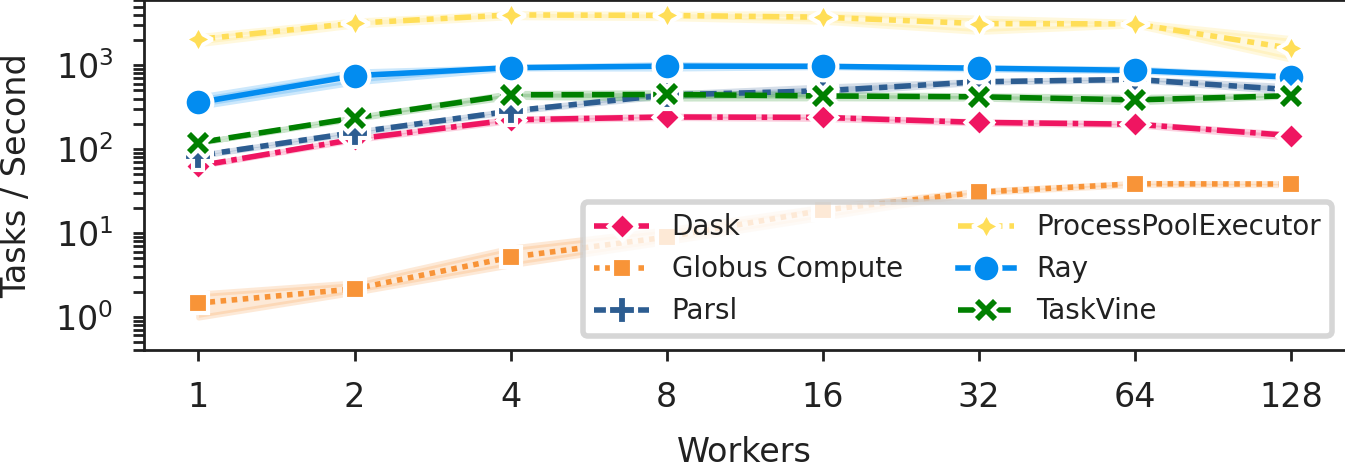

In [17]:
fig, ax = plt.subplots(1, 1)

colors = {
    'Dask': '#EF1561',
    'Globus Compute': '#F89438',
    'Parsl': '#2D5D91',
    'ProcessPoolExecutor': '#FFDE57',
    'Ray': '#028CF0',
    'TaskVine': '#008000',
}

names = {
    'dask': 'Dask',
    'globus-compute': 'Globus Compute',
    'parsl': 'Parsl',
    'process-pool': 'ProcessPoolExecutor',
    'ray': 'Ray',
    'taskvine': 'TaskVine',
}
data_ = data.with_columns(polars.col('executor').replace(names, default=None))

seaborn.lineplot(
    ax=ax,
    data=data_,
    x='workers',
    y='task-rate',
    hue='executor',
    hue_order=sorted(names.values()),
    palette=colors,
    markers=True,
    style='executor',
    linewidth=1,
    markersize=5,
)
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)

ax.set_ylabel('Tasks / Second')
ax.set_xlabel('Workers')
workers = sorted(set(data_['workers']))
ax.set_xticks(workers, workers)

ax.set_ylim([0.4, 6000])

ax.legend(loc='lower right', title=None, ncol=2, fontsize=5)
# ax.legend(loc='center left', title=None, ncol=1, fontsize=5, bbox_to_anchor=(1, 0.5))

fig.tight_layout()
fig.set_size_inches(3.35, 1)
plt.savefig('../figures/scaling.pdf', pad_inches=0.05)
plt.savefig('../figures/scaling.svg', pad_inches=0.05)